# Code 1

In [1]:
# Step 1: Set Up Environment and Install Dependencies
!pip install -q pandas numpy scikit-learn nltk textblob spacy transformers sentence-transformers
!python -m spacy download en_core_web_sm

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import hstack

nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

print("Environment setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Environment setup complete!


In [2]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (adjust path if needed)
data_path = '/content/drive/MyDrive/Dataset/movie_review.csv'  # Update to your path
df = pd.read_csv(data_path)

print("Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")
print("Sentiment distribution:", df['tag'].value_counts())

Mounted at /content/drive
Dataset loaded:
   fold_id cv_tag  html_id  sent_id  \
0        0  cv000    29590        0   
1        0  cv000    29590        1   
2        0  cv000    29590        2   
3        0  cv000    29590        3   
4        0  cv000    29590        4   

                                                text  tag  
0  films adapted from comic books have had plenty...  pos  
1  for starters , it was created by alan moore ( ...  pos  
2  to say moore and campbell thoroughly researche...  pos  
3  the book ( or " graphic novel , " if you will ...  pos  
4  in other words , don't dismiss this film becau...  pos  
Shape: (64720, 6)
Sentiment distribution: tag
pos    32937
neg    31783
Name: count, dtype: int64


In [3]:
# Step 3: Select Relevant Columns and Preprocess
# Keep only 'Issue' and 'Sub-issue'
df = df[['text', 'tag']]

# Fill NaN in 'Sub-issue' with empty string to avoid errors
df['text'] = df['text'].fillna("")
df['tag'] = df['tag'].fillna("")

# Example: If you want to classify based on 'Issue' only
# Use 'Issue' as label
le = LabelEncoder()
df['issue_encoded'] = le.fit_transform(df['tag'])
print("Encoded classes:", le.classes_)

# Train-test split (80/20)
X = df['text']
y = df['issue_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data prepared. Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train set issue distribution:\n", pd.Series(y_train).value_counts())
print("Test set issue distribution:\n", pd.Series(y_test).value_counts())

Encoded classes: ['neg' 'pos']
Data prepared. Train shape: (51776,) Test shape: (12944,)
Train set issue distribution:
 issue_encoded
1    26364
0    25412
Name: count, dtype: int64
Test set issue distribution:
 issue_encoded
1    6573
0    6371
Name: count, dtype: int64


In [4]:
# Step 4: Rule-Based Model with Enhanced Negation Handling
def rule_based_sentiment(text):
    # VADER sentiment
    vader_score = sia.polarity_scores(text)['compound']

    # Enhance with spaCy negation detection
    doc = nlp(text)
    negation = any(token.dep_ == 'neg' for token in doc)

    # Adjust thresholds and handle negations
    if negation and vader_score > 0:
        return 0  # Flip to Negative if negation detected
    elif vader_score > 0.1:  # Tighter threshold for Positive
        return 1  # Positive (changed from 2)
    elif vader_score < -0.1:  # Tighter threshold for Negative
        return 0  # Negative
    else:
        # Since there's no 'Neutral' in this dataset, we'll assign close scores
        # to the closest sentiment or re-evaluate. For now, assign to the dominant class if no strong sentiment.
        # This part might need adjustment based on how 'neutral' should be handled in a binary classification context.
        # Given the dataset only has 'Negative' and 'Positive', we'll force a binary output.
        return 1 if vader_score >= 0 else 0


# Apply to test set
y_pred_rule = [rule_based_sentiment(text) for text in X_test]

# Evaluate Rule-Based
print("Rule-Based Evaluation:")
# Ensure target_names matches the actual classes present
print(classification_report(y_test, y_pred_rule, target_names=le.classes_, zero_division=0))
acc_rule = accuracy_score(y_test, y_pred_rule)

Rule-Based Evaluation:
              precision    recall  f1-score   support

         neg       0.53      0.44      0.48      6371
         pos       0.53      0.62      0.57      6573

    accuracy                           0.53     12944
   macro avg       0.53      0.53      0.53     12944
weighted avg       0.53      0.53      0.53     12944



In [ ]:
# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-3 grams), Evaluation
# Vectorizer for n-grams (reduced features to prevent overfitting)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model 1: Logistic Regression (with regularization)
lr_model = LogisticRegression(max_iter=1000, C=0.5)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# Model 2: SVM
svm_model = SVC(kernel='linear', C=0.5)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.63      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944

SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.63      6371
         pos       0.64      0.63      0.64      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944

Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.68      0.20      0.31      6371
         pos       0.54      0.91      0.68      6573

    accuracy                           0.56     12944
   macro avg       0.61      0.56      0.49     12944


# Separate Testing

In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-2 grams), Evaluation
# Improved Vectorizer: wider n-grams, higher features, min_df to reduce noise
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model 1: Logistic Regression with hyperparameter tuning
lr_param_grid = {'C': [0.1, 0.5, 1.0, 5.0]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# Model 2: SVM with hyperparameter tuning
svm_param_grid = {'C': [0.1, 0.5, 1.0, 5.0]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Model 3: Random Forest with improved params and tuning
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}  # Tune depth and trees
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)
y_pred_rf = rf_grid.best_estimator_.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

# New Model 4: Multinomial Naive Bayes (great for TF-IDF text classification)
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha=0.5)  # Smoothing parameter; can tune if needed
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
acc_nb = accuracy_score(y_test, y_pred_nb)
print("Multinomial Naive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_, zero_division=0))

# Optional: Inspect top features from RF (for debugging/improvement)
importances = rf_grid.best_estimator_.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_features = sorted(zip(importances, feature_names), reverse=True)[:10]
print("Top 10 Features by Importance:", top_features)

In [5]:
from sklearn.model_selection import GridSearchCV

# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-2 grams), Evaluation
# Improved Vectorizer: wider n-grams, higher features, min_df to reduce noise
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
# Model 1: Logistic Regression with hyperparameter tuning c = 0.1
lr_param_grid = {'C': [0.1]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Logistic Regression Best Params: {'C': 0.1}
Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.62      0.63      6371
         pos       0.65      0.68      0.67      6573

    accuracy                           0.65     12944
   macro avg       0.65      0.65      0.65     12944
weighted avg       0.65      0.65      0.65     12944



In [7]:
# Model 1: Logistic Regression with hyperparameter tuning c = 0.5
lr_param_grid = {'C': [0.5]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Logistic Regression Best Params: {'C': 0.5}
Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.66      0.65      0.65      6371
         pos       0.66      0.67      0.67      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [8]:
# Model 1: Logistic Regression with hyperparameter tuning c = 1.0
lr_param_grid = {'C': [1.0]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Logistic Regression Best Params: {'C': 1.0}
Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.65      0.65      6371
         pos       0.67      0.67      0.67      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [9]:
# Model 1: Logistic Regression with hyperparameter tuning c = 5.0
lr_param_grid = {'C': [5.0]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Logistic Regression Best Params: {'C': 5.0}
Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.66      0.65      6371
         pos       0.66      0.66      0.66      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [10]:
# Model 1: Logistic Regression with hyperparameter tuning c = 10.0
lr_param_grid = {'C': [10.0]}  # Tune regularization strength
lr_model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy')
lr_grid.fit(X_train_tfidf, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Best Params:", lr_grid.best_params_)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

Logistic Regression Best Params: {'C': 10.0}
Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.66      0.65      6371
         pos       0.67      0.66      0.66      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [11]:
# Model 2: SVM with hyperparameter tuning c = 0.1
svm_param_grid = {'C': [0.1]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Best Params: {'C': 0.1}
SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.66      0.61      0.63      6371
         pos       0.65      0.69      0.67      6573

    accuracy                           0.65     12944
   macro avg       0.65      0.65      0.65     12944
weighted avg       0.65      0.65      0.65     12944



In [13]:
# Model 2: SVM with hyperparameter tuning c = 0.5
svm_param_grid = {'C': [0.5]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Best Params: {'C': 0.5}
SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.66      0.66      6371
         pos       0.67      0.66      0.66      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [14]:
# Model 2: SVM with hyperparameter tuning c = 1.0
svm_param_grid = {'C': [1.0]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

SVM Best Params: {'C': 1.0}
SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.65      0.66      0.66      6371
         pos       0.67      0.65      0.66      6573

    accuracy                           0.66     12944
   macro avg       0.66      0.66      0.66     12944
weighted avg       0.66      0.66      0.66     12944



In [ ]:
# Model 2: SVM with hyperparameter tuning c = 5.0
svm_param_grid = {'C': [5.0]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

In [ ]:
# Model 2: SVM with hyperparameter tuning c = 10.0
svm_param_grid = {'C': [10.0]}  # Tune penalty
svm_model = SVC(kernel='linear')
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Best Params:", svm_grid.best_params_)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

In [12]:
# Model 3: Random Forest with improved params and tuning
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}  # Tune depth and trees
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)
y_pred_rf = rf_grid.best_estimator_.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Random Forest Best Params: {'max_depth': None, 'n_estimators': 200}
Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.63      0.63      6371
         pos       0.64      0.65      0.65      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944



In [ ]:
# Step 7: Hybrid Approach (Combine Rule-Based Scores with ML Features)
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1)
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1)

# Combine TF-IDF with rule-based scores
X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

# Train Hybrid on Logistic Regression
hybrid_model = LogisticRegression(max_iter=1000, C=0.5)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Hybrid Model Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.62      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944



Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based  0.531211           0.530824        0.529773   
1  Logistic Regression  0.635893           0.635790        0.635767   
2                  SVM  0.634734           0.634743        0.634776   
3        Random Forest  0.560878           0.611025        0.555366   
4               Hybrid  0.632726           0.632624        0.632605   

   F1-Score (macro)  
0          0.526435  
1          0.635775  
2          0.634715  
3          0.494711  
4          0.632612  


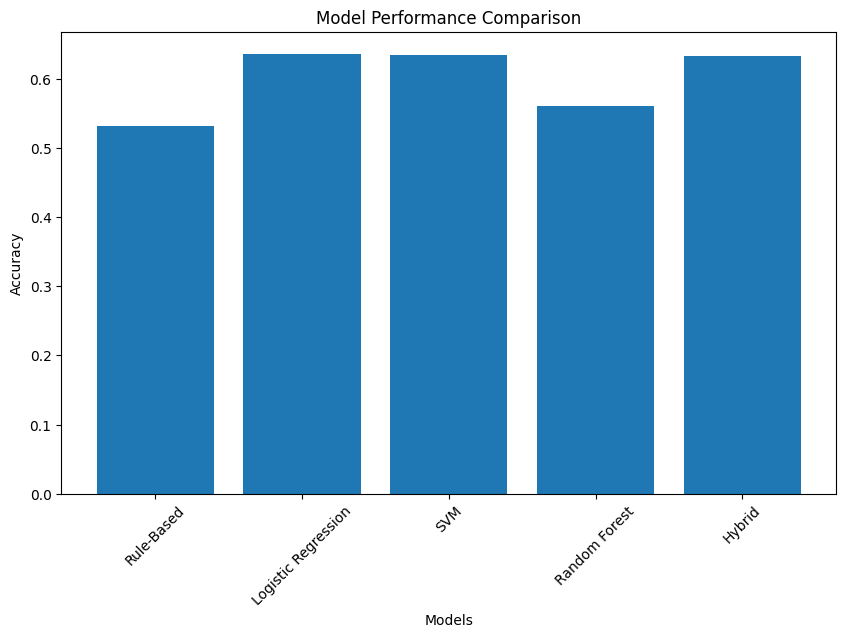

In [ ]:
# Step 8: Compare All Models
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'Recall (macro)': [recall_score(y_test, y_pred_rule, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'F1-Score (macro)': [f1_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_hybrid, average='macro', zero_division=0)]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Step 9: Input Different Reviews and Compare Results
def predict_sentiment(new_review):
    tfidf_vec = vectorizer.transform([new_review])
    rule_score = np.array([sia.polarity_scores(new_review)['compound']]).reshape(-1, 1)
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(new_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    # Decode labels - ensure inverse_transform is called with valid predicted labels
    # The models might predict 0 or 1, which correspond to 'Negative' and 'Positive'
    preds = {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }
    return preds

# Test new reviews
new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine." ,
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nReview: {review}")
    print(predict_sentiment(review))


Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Hybrid': 'pos'}

Review: This product is terrible, broke after a week.
{'Rule-Based': 'neg', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'neg', 'Hybrid': 'neg'}

Review: It's okay, nothing special but works fine.
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Hybrid': 'pos'}

Review: False statements or representation
{'Rule-Based': 'pos', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'pos', 'Hybrid': 'neg'}
